In [1]:
from utils.analysis import Signal

Welcome to JupyROOT 6.24/06


In [2]:
indir = f"root://cmseos.fnal.gov//store/user/srosenzw/sixb/ntuples/Summer2018UL/bias/"
datFileName = f"{indir}JetHT_Data_UL/JetHT_Run2018_full/ntuple.root"
datTree = Signal(datFileName)

In [3]:
from configparser import ConfigParser

cfg = 'config/sphereConfig_bias.cfg'

config = ConfigParser()
config.optionxform = str
config.read(cfg)

base = config['file']['base']
data = config['file']['data']

indir = f"root://cmseos.fnal.gov/{base}"
datFileName = f"{indir}{data}"
datTree = Signal(datFileName)
region_type = 'sphere'

variables = config['BDT']['variables']
variables = variables.split(', ')

datTree.spherical_region(config)

VR_center   = 174
SR_edge     = 30
CR_edge     = 40
--------------------



In [4]:
datTree.bdt_process(region_type, config)

.. training BDT in V_CR
.. calling reweight.GBReweighter
.. calling reweight.FoldingReweighter
.. calling reweighter.fit
.. predicting weights in CR

.. predicting weights in V_SR

.. training BDT in A_CR
.. calling reweight.GBReweighter
.. calling reweight.FoldingReweighter
.. calling reweighter.fit

.. predicting weights in A_SR



Pull distributions

In [5]:
hs_mask = datTree.V_SRhs_mask
ls_mask = datTree.V_SRls_mask
weights = datTree.V_SR_weights

In [6]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from scipy.optimize import curve_fit
from matplotlib.patches import Rectangle
from scipy.stats import chisquare

In [7]:
def gauss(x, H, A, x0, sigma):
   return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def kernel_func(X, h, xi):
   A = 1/(h*np.sqrt(2*np.pi))
   B = -0.5*(X-xi)**2/h**2
   return A*np.exp(B)

In [76]:
datTree.keys()

['Run',
 'LumiSec',
 'Event',
 'n_other_pv',
 'rhofastjet_all',
 'X_m',
 'X_pt',
 'X_eta',
 'X_phi',
 'Y_m',
 'Y_pt',
 'Y_eta',
 'Y_phi',
 'HX_m',
 'HX_pt',
 'HX_eta',
 'HX_phi',
 'HY1_m',
 'HY1_pt',
 'HY1_eta',
 'HY1_phi',
 'HY2_m',
 'HY2_pt',
 'HY2_eta',
 'HY2_phi',
 'HX_b1_m',
 'HX_b1_pt',
 'HX_b1_ptRegressed',
 'HX_b1_eta',
 'HX_b1_phi',
 'HX_b1_btag',
 'HX_b2_m',
 'HX_b2_pt',
 'HX_b2_ptRegressed',
 'HX_b2_eta',
 'HX_b2_phi',
 'HX_b2_btag',
 'HY1_b1_m',
 'HY1_b1_pt',
 'HY1_b1_ptRegressed',
 'HY1_b1_eta',
 'HY1_b1_phi',
 'HY1_b1_btag',
 'HY1_b2_m',
 'HY1_b2_pt',
 'HY1_b2_ptRegressed',
 'HY1_b2_eta',
 'HY1_b2_phi',
 'HY1_b2_btag',
 'HY2_b1_m',
 'HY2_b1_pt',
 'HY2_b1_ptRegressed',
 'HY2_b1_eta',
 'HY2_b1_phi',
 'HY2_b1_btag',
 'HY2_b2_m',
 'HY2_b2_pt',
 'HY2_b2_ptRegressed',
 'HY2_b2_eta',
 'HY2_b2_phi',
 'HY2_b2_btag',
 'n_mu_loose',
 'n_ele_loose',
 'mu_1_m',
 'mu_1_pt',
 'mu_1_eta',
 'mu_1_phi',
 'mu_2_m',
 'mu_2_pt',
 'mu_2_eta',
 'mu_2_phi',
 'ele_1_m',
 'ele_1_pt',
 'ele_1_eta',

42.64244946801557 0.27823771741858444


Text(0.99, 0.99, 'mean = 0.126+-0.167\nstd = 0.817+-0.227')

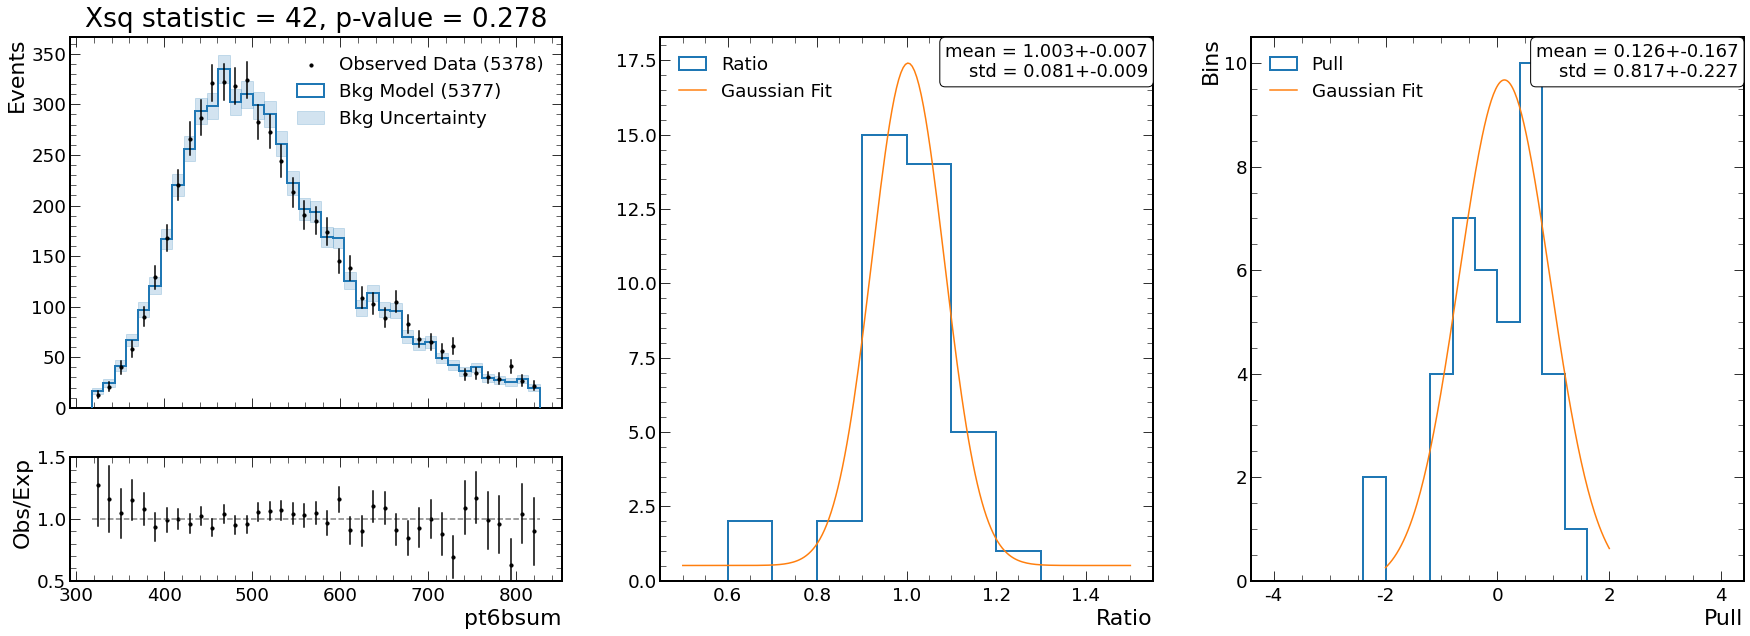

In [111]:
var = variables[0]
original = datTree.np(var)[ls_mask]
target = datTree.np(var)[hs_mask]

nbins = 40
bmin = target.min()
bmax = target.max()
bins = np.linspace(bmin, bmax, nbins)
x = (bins[:-1] + bins[1:]) / 2

n_target, e = np.histogram(target, bins=bins)
bmax = e[:-1][n_target > 0.05*n_target.max()][-1]
bmin = e[:-1][n_target > 0.05*n_target.max()][0]
bins = np.linspace(bmin, bmax, nbins)
x = (bins[:-1] + bins[1:]) / 2

n_target, e = np.histogram(target, bins=bins)

weights = weights * n_target.sum() / weights[(original >= bmin) & (original < bmax)].sum()
n_model, e  = np.histogram(original, bins=bins, weights=weights)
Xsq, p = chisquare(n_target, n_model)
print(Xsq, p)
Xsq, p = int(Xsq), round(p, 3)

fig = plt.figure(figsize=(30,10))
GS = GridSpec(1, 3, figure=fig)

gs1 = GridSpecFromSubplotSpec(2, 1, subplot_spec=GS[0], height_ratios=[3,1])
gs2 = GridSpecFromSubplotSpec(1, 1, subplot_spec=GS[1])
gs3 = GridSpecFromSubplotSpec(1, 1, subplot_spec=GS[2])

ax1t = fig.add_subplot(gs1[0])
ax1b = fig.add_subplot(gs1[1])
ax2 = fig.add_subplot(gs2[0])
ax3 = fig.add_subplot(gs3[0])

# DISTRIBUTION plots on LEFT axis

ax1t.set_title(f"Xsq statistic = {round(Xsq)}, p-value = {round(p, 3)}")

n_model = Hist(x, weights=n_model, bins=bins, ax=ax1t, zorder=9)
_ = ax1t.plot([x,x],[n_target+np.sqrt(n_target), n_target-np.sqrt(n_target)], color='k', zorder=10)
scatter = ax1t.scatter(x, n_target, s=10, c='k', zorder=10)
handles = [Rectangle([0,0],1,1,color='C0', fill=False, lw=2), Rectangle([0,0],1,1,color='C0', alpha=0.2)]
labels=[f'Bkg Model ({int(n_model.sum())})', 'Bkg Uncertainty']
handles.insert(0,scatter)
labels.insert(0, f'Observed Data ({int(n_target.sum())})')
ax1t.legend(handles=handles, labels=labels)

bin_error_model = np.array(())
for X,n,l in zip(x, n_model, bins):
   width = X - l
   r = X + width
   est_mask = (original >= X - width) & (original < X + width)
   est_err = np.sqrt(np.sum(weights[est_mask]**2))
   bin_error_model = np.append(bin_error_model, np.sum(weights[est_mask]**2))
   ax1t.fill_between([l, r], n-est_err, n+est_err, color='C0', alpha=0.2, zorder=0)

   # est_err_hi = np.where(n == 0, 1 + est_err, (n + est_err) / n)
   # est_err_lo =  np.where(n == 0, 1 - est_err, (n - est_err) / n)
   # ax1b.fill_between([l, r], est_err_lo, est_err_hi, color='C0', alpha=0.2)

ax1t.axes.set_xticklabels([])
ax1t.set_ylabel('Events')

ratio = np.nan_to_num(n_model / n_target, 1)
ratio = np.where(ratio > 10**5, 1, ratio)
ratio = np.where(ratio == 0, 1, ratio)
error = np.sqrt(bin_error_model/n_model**2 + 1/n_target) # 

ax1b.plot([bins[0], bins[-1]], [1, 1], color='grey', linestyle='--')
n_ratio, e = np.histogram(x, weights=ratio, bins=bins)
_ = ax1b.scatter(x, n_ratio, s=10, c='k')
ax1b.plot([x,x],[n_ratio+error,n_ratio-error], color='k')
ax1b.set_xlabel(var)
ax1b.set_ylabel('Obs/Exp')
ax1b.set_ylim(0.5,1.5)

# RATIO plots on MIDDLE axis

rBins = np.arange(0.5,1.5,0.1)
rX = (rBins[:-1] + rBins[1:]) / 2
n_ratio = Hist(ratio, bins=rBins, ax=ax2, label='Ratio')
ax2.set_xlabel('Ratio')

mean = (rX*n_ratio).sum()/n_ratio.sum()
sigma = np.sqrt(sum(n_ratio * (rX-mean) ** 2) / sum(n_ratio))

X = np.linspace(0.5,1.5,200)
params, covar = curve_fit(gauss, rX, n_ratio, p0=[min(n_ratio), max(n_ratio), mean, sigma])
H, A, x0, s = params
y = gauss(X, H, A, x0, s)
std = np.around(np.sqrt(np.diag(covar)),3)

ax2.plot(X, y, label='Gaussian Fit')
ax2.legend(loc=2)
box = {
   'boxstyle' :'round',
   'fc' : 'white'
}
ax2.text(.99,.99,f"mean = {round(x0,3)}+-{std[2]}\nstd = {round(s,3)}+-{std[3]}", transform=ax2.transAxes, bbox=box, fontsize=18, va='top', ha='right')

# PULL plots on RIGHT axis

bins = np.arange(-3,3.0001,0.5)
diff = n_model - n_target
e_diff = np.sqrt(n_target + bin_error_model)
# e_diff = np.sqrt(n_target)
pull = diff / e_diff
n_pull, e = np.histogram(pull, bins=bins)
# N_pull = Hist(pull, bins=np.linspace(-4,4,41), ax=ax3, align='mid', label='Pull')
N_pull = Hist(pull, bins=np.arange(-4,4.0001,0.4), ax=ax3, align='mid', label='Pull')

# x = bins[:-1]
x = (bins[:-1] + bins[1:]) / 2
X = np.linspace(-2,2,200)
# h = 1
# pull_smear = np.zeros_like(X)
# Npull, e = np.histogram(pull, bins=X)
# for xi,n in zip(e[:-1],Npull):
#    if n == 0: continue
#    K = kernel_func(X, h, xi)
#    pull_smear += K
# ax3.plot(X, pull_smear, label='Smeared Pull')

ax3.set_xlabel('Pull')
ax3.set_ylabel('Bins')

mean = (x*n_pull).sum()/n_pull.sum()
sigma = np.sqrt(sum(n_pull * (x-mean) ** 2) / sum(n_pull))

params, covar = curve_fit(gauss, x, n_pull, p0=[min(n_pull), max(n_pull), mean, sigma])
H, A, x0, s = params
y = gauss(X, H, A, x0, s)
std = np.around(np.sqrt(np.diag(covar)),3)

ax3.plot(X, y, label='Gaussian Fit')
ax3.legend(loc=2)
box = {
   'boxstyle' :'round',
   'fc' : 'white'
}
ax3.text(.99,.99,f"mean = {round(x0,3)}+-{std[2]}\nstd = {round(s,3)}+-{std[3]}", transform=ax3.transAxes, bbox=box, fontsize=18, va='top', ha='right')

# x_gauss = np.linspace(-4,4,100)
# y = gauss(x_gauss, 0, 8, 0, 1)
# ax3.plot(x_gauss, y, label='Desired Gaussian')


In [63]:
print(params)
print(covar.round(3))
print(np.sqrt(np.diag(covar)))

[-0.06423866 10.00868545  0.06778254  0.95762637]
[[ 1.173 -0.856  0.    -0.153]
 [-0.856  1.705 -0.     0.043]
 [ 0.    -0.     0.013 -0.   ]
 [-0.153  0.043 -0.     0.033]]
[1.08313995 1.30561585 0.1147617  0.18212764]


In [45]:
%run scripts/bdt_pull_plots.py

['pt6bsum', 'dR6bmin', 'HY1_pt', 'HY2_pt', 'HX_pt', 'HY1_dr', 'HY1_dr', 'HY2_dr', 'HX_dr', 'HX_m', 'HY1_m', 'HY1_HY2_dEta', 'HY2_HX_dEta', 'HX_HY1_dEta', 'HX_HY1_dPhi', 'HY1_HY2_dPhi', 'HY2_HX_dPhi', 'HY1_HY2_dR', 'HX_HY2_dR', 'HX_HY1_dR', 'HY1_costheta', 'HY2_costheta', 'HX_costheta'] 

VR_center   = 174
SR_edge     = 30
CR_edge     = 40
--------------------

.. training BDT in V_CR
.. calling reweight.GBReweighter
.. calling reweight.FoldingReweighter
.. calling reweighter.fit
.. predicting weights in CR

.. predicting weights in V_SR

.. training BDT in A_CR
.. calling reweight.GBReweighter
.. calling reweight.FoldingReweighter
.. calling reweighter.fit

.. predicting weights in A_SR

pt6bsum
.. saving fig

dR6bmin
.. saving fig

HY1_pt
.. saving fig

HY2_pt
.. saving fig

HX_pt
.. saving fig

HY1_dr
.. saving fig

HY1_dr
.. saving fig

HY2_dr
.. saving fig

HX_dr
.. saving fig

HX_m
.. saving fig

HY1_m
.. saving fig

HY1_HY2_dEta
.. saving fig

HY2_HX_dEta
.. saving fig

HX_HY1_dE

In [74]:
G_df

,mean,s
pt6bsum,-0.482,0.896
dR6bmin,-0.402,0.958
HY1_pt,-0.204,1.905
HY2_pt,-0.194,0.660
HX_pt,-0.123,1.113
HY1_dr,-0.116,0.897
HY1_dr,-0.099,0.897
HY2_dr,-0.088,0.747
HX_dr,-0.083,0.950
HX_m,-0.072,1.158


In [76]:
import pandas as pd

In [89]:
G = np.column_stack((means, sigmas))
G_df = DataFrame(G, index=variables+['X_m'], columns=['mean', 's'])
G_df

all_df = pd.concat((X_df, G_df), axis=1)
all_df

,Xsq,p,mean,s
HX_m,71.0,0.110,-0.072,1.158
pt6bsum,74.0,0.075,-0.482,0.896
HY1_HY2_dEta,75.0,0.062,-0.052,1.160
HY1_dr,76.0,0.055,-0.116,0.897
HY1_dr,76.0,0.055,-0.099,0.897
HY1_HY2_dPhi,79.0,0.034,0.027,1.067
HX_HY1_dEta,82.0,0.021,0.009,1.031
HY2_HX_dPhi,83.0,0.016,0.036,0.821
HY1_m,87.0,0.007,-0.056,1.065
HY2_HX_dEta,91.0,0.003,0.009,0.754


In [95]:
s_minus_1 = all_df['s'].to_numpy() - 1

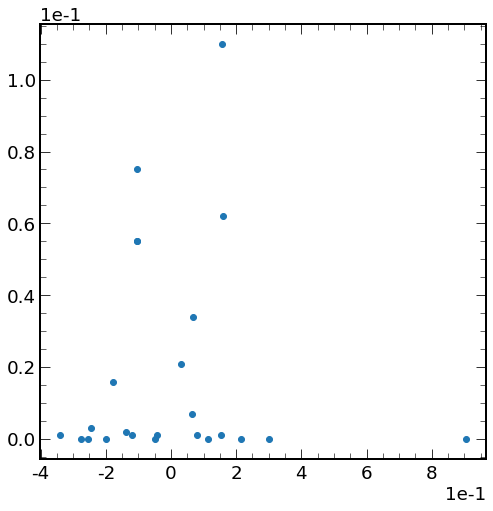

In [97]:
plt.scatter(s_minus_1, p)

In [77]:
from scipy.stats import chi2

0.2715449851181677
52.577404554294915


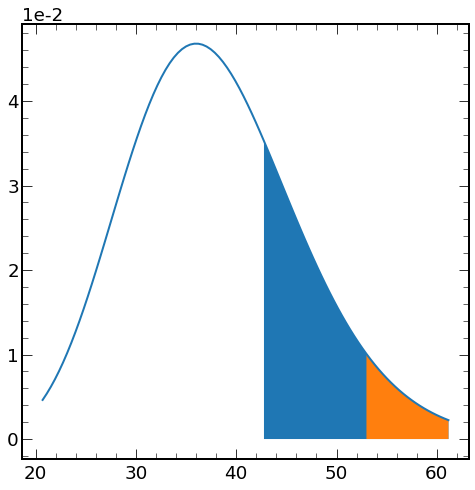

In [127]:
fig, ax = plt.subplots()

df = 38
mean, var, skew, kurt = chi2.stats(df, moments='mvsk')
x = np.linspace(chi2.ppf(0.01, df), chi2.ppf(0.99, df), 100)
y = chi2.pdf(x, df)
ax.plot(x, y, lw=2, label='chi2 pdf')
dx = x[1] - x[0]
stat = 42.64244946801557
ax.fill_between(x[x > stat], chi2.pdf(x[x > stat], df))
print((chi2.pdf(x[x >= stat], df)*dx).sum())
# print(chi2.pdf(x[x > stat], df).sum())
cl_95 = x[y.cumsum()/y.sum() >= 0.95][0]
print(cl_95)
ax.fill_between(x[x > cl_95], y[x > cl_95])